In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from wvz_helpers import skims, load_dataframes, yields_map

from geeksw.stats.binning import RectangularBinningModel

In [2]:
backgrounds = ["zz",
    "ttz",
    "twz",
    "wz",
    "higgs",
    "othernoh",
]

signals = [
    "nonh_wwz", "vh_wwz",
    "nonh_wzz", "vh_wzz",
    "nonh_zzz", "vh_zzz",
]

In [3]:
background_samples = []
for b in backgrounds:
    background_samples += yields_map[b]
data_background = load_dataframes(background_samples, concat=True, exclude_training=True)

In [4]:
signal_samples = []
for b in signals:
    signal_samples += yields_map[b]
data_signal = load_dataframes(signal_samples, concat=True, exclude_training=True)

In [5]:
data_background["is_signal"] = False
data_signal["is_signal"] = True

In [6]:
data = pd.concat([data_signal, data_background], ignore_index=True)
data = data.query("is_ChannelEMu").copy()

In [7]:
X = data[["bdt_EMu_wwz_vs_zz", "bdt_EMu_wwz_vs_ttz"]].values

In [8]:
y = data.eval("is_signal == 1").values
w = data["weight"].values

In [9]:
data.query("is_signal == 1")["weight"].sum()

15.208645207442483

In [10]:
data.query("is_signal == 0")["weight"].sum()

27.200078192295503

In [11]:
box_model = RectangularBinningModel(max_depth=5, snap_boxes_to_full_phasespace=True).fit(X, y, sample_weight=w)

In [12]:
data["fitting_bin"] = box_model.apply(X)

In [13]:
def L(s, b):
    return np.sqrt(2. * ((s+b) * np.log(1 + s/b)  -s ) )

In [14]:
def make_summary_df(data):
    data_signal = data.query("is_signal == 1")
    data_background = data.query("is_signal == 0")
    df = pd.DataFrame()
    df["s"] = data_signal.groupby("fitting_bin")["weight"].sum()
    df["b"] = data_background.groupby("fitting_bin")["weight"].sum()
    df["s/b"] = df["s"]/df["b"]
    df["s_rel_uncert [%]"] = 1./np.sqrt(data_signal.groupby("fitting_bin")["weight"].count()) * 100
    df["b_rel_uncert [%]"] = 1./np.sqrt(data_background.groupby("fitting_bin")["weight"].count()) * 100
    df["L"] = L(df["s"], df["b"])
    df.loc["total", ["s", "b"]] = df[["s", "b"]].sum()
    df.loc["combined", "L"] = np.sqrt((df["L"].dropna()**2).sum())
    df.loc["total", "s_rel_uncert [%]"] = 1./np.sqrt(data_signal["weight"].count()) * 100
    df.loc["total", "b_rel_uncert [%]"] = 1./np.sqrt(data_background["weight"].count()) * 100
    return df

In [15]:
df = make_summary_df(data)

/usr/lib/python3.8/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
df

s          b       s/b  s_rel_uncert [%]  \
fitting_bin                                                     
-1            0.007618  -0.027777 -0.274250          7.692308   
0             0.622415  11.038950  0.056384          1.380131   
1             1.107274   5.238013  0.211392          0.865614   
2             0.304445   1.249939  0.243568          1.228868   
3             1.988647   3.399566  0.584971          0.598770   
4             1.095931   1.873941  0.584827          0.824590   
5             0.630847   0.491569  1.283334          1.126729   
6             6.055392   3.480079  1.740016          0.329238   
7             3.396077   0.455798  7.450831          0.505942   
total        15.208645  27.200078       NaN          0.219697   
combined           NaN        NaN       NaN               NaN   

             b_rel_uncert [%]         L  
fitting_bin                              
-1                  25.000000       NaN  
0                    1.376335  0.185613  
1                    1.960784  0.468107  
2                    5.143445  0.262247  
3                    3.487901  0.992956  
4                    3.555591  0.737050  
5                    6.666667  0.769234  
6                    3.210806  2.666839  
7                    7.372098  3.106395  
total                0.942139       NaN  
combined                  NaN  4.382351

In [17]:
new_boxes = box_model.boxes_.copy(deep=True)
new_boxes.loc[0, "xmax"] = new_boxes.loc[1, "xmax"]
new_boxes.loc[2, "ymax"] = new_boxes.loc[3, "ymax"]
new_boxes.loc[2, "xmin"] = new_boxes.loc[3, "xmin"]
new_boxes.loc[4, "xmax"] = new_boxes.loc[5, "xmax"]
new_boxes = new_boxes.drop([1, 3, 5])
new_boxes.index = range(len(new_boxes))
new_boxes

xmin      xmax       ymin       ymax
0      -inf -0.907694       -inf        inf
1 -0.907694       inf       -inf  0.0148177
2 -0.907694  0.732684  0.0148177        inf
3  0.732684       inf  0.0148177    3.52336
4  0.732684       inf    3.52336        inf

In [18]:
manual_box_model = RectangularBinningModel.from_pandas(new_boxes)
data["fitting_bin"] = manual_box_model.apply(X)

In [19]:
df = make_summary_df(data)
df

s          b       s/b  s_rel_uncert [%]  \
fitting_bin                                                     
0             1.729688  16.276963  0.106266          0.733314   
1             2.300710   4.621729  0.497803          0.536960   
2             1.726778   2.365509  0.729982          0.665426   
3             6.055392   3.480079  1.740016          0.329238   
4             3.396077   0.455798  7.450831          0.505942   
total        15.208645  27.200078       NaN          0.219697   
combined           NaN        NaN       NaN               NaN   

             b_rel_uncert [%]         L  
fitting_bin                              
0                    1.126515  0.421452  
1                    2.867697  0.995942  
2                    3.137279  1.016119  
3                    3.210806  2.666839  
4                    7.372098  3.106395  
total                0.942139       NaN  
combined                  NaN  4.354738

In [20]:
formatter = lambda x: "{:.2f}".format(x) if not np.isnan(x) else "--"
df.to_html("plots/EMu_2D_yields.html", formatters=[formatter] * len(df.columns))

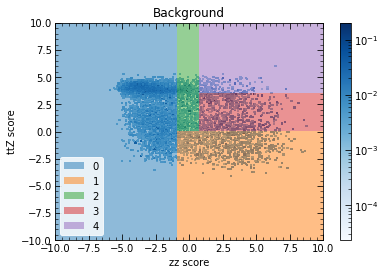

In [21]:
plt.figure()
bins = np.linspace(-10, 10, 200)
plt.hist2d(X[y == 0,0], X[y==0,1], weights=w[y==0], bins=[bins,bins], norm=mpl.colors.LogNorm(), cmap=mpl.cm.Blues)
plt.colorbar()
manual_box_model.visualize(alpha=0.5)
plt.legend(loc="lower left")
plt.title("Background")
plt.ylabel("ttZ score")
plt.xlabel("zz score")
plt.savefig("plots/emu_bdt_2d_background.pdf")
plt.savefig("plots/emu_bdt_2d_background.png", dpi=300)
plt.show()

In [22]:
plt.figure()
bins = np.linspace(-10, 10, 200)
plt.hist2d(X[y == 1,0], X[y==1,1], weights=w[y==1], bins=[bins,bins], norm=mpl.colors.LogNorm(), cmap=mpl.cm.Reds)
plt.colorbar()
manual_box_model.visualize(alpha=0.5)
plt.legend(loc="lower left")
plt.title("Signal")
plt.ylabel("ttZ score")
plt.xlabel("zz score")
plt.savefig("plots/emu_bdt_2d_signal.pdf")
plt.savefig("plots/emu_bdt_2d_signal.png", dpi=300)
plt.show()

In [24]:
import pickle

with open('models/EMu2DBinning.pickle', 'wb') as handle:
    pickle.dump(manual_box_model, handle, protocol=pickle.HIGHEST_PROTOCOL)